In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import pickle

import sys
sys.path.append("..")

import neuroprob as mdl
import neuroprob.utils as utils



dev = utils.pytorch.get_device()


PyTorch version: 1.12.1+cu102
Using device: cuda:0


In [22]:
mouse_ids = ['Mouse24', 'Mouse24', 'Mouse28', 'Mouse28', 'Mouse25', 'Mouse25'] # 'Mouse12'
session_ids = ['131213', '131216', '140312', '140313', '140123', '140124'] # '120806'


k = 3
mouse_id, session_id = mouse_ids[k], session_ids[k]
phase = 'wake'
datadir = '/scratches/ramanujan_2/dl543/HDC_PartIII'

data_dict = pickle.load(open(datadir+'/th1_{}_{}_{}.p'.format(mouse_id, session_id, phase), 'rb'))


[7.16711559e-02 1.12517316e-01 8.29165570e-03 1.17699809e-03
 1.93094362e-01 6.54008439e-02 3.53218477e-02 1.56862745e-03
 0.00000000e+00 0.00000000e+00 1.18343195e-03 0.00000000e+00
 9.49066751e-04 4.63597579e-03 8.09855036e-05 6.80941947e-03
 0.00000000e+00 5.02669858e-02 5.21522036e-02 1.86915888e-03
 0.00000000e+00 1.37213837e-03 2.73224044e-04 2.13289582e-03
 8.50340136e-04 0.00000000e+00 1.00959112e-03 0.00000000e+00
 0.00000000e+00 2.28800057e-03 1.68406871e-04 3.62750687e-04
 2.27001195e-03 6.52528548e-02 1.10255877e-02 3.04414003e-03
 0.00000000e+00 5.51571980e-04 3.75318260e-04 0.00000000e+00
 2.02307398e-03 1.07372711e-01 1.43239041e-01 7.33552822e-03
 3.32889481e-04 0.00000000e+00 1.84842884e-03 4.66399782e-04
 2.52716705e-04 5.02665651e-02 1.03954448e-02 4.83900626e-05
 7.74293457e-04 5.16730199e-02 8.48592303e-02 0.00000000e+00
 4.54338937e-04 1.05384173e-03 2.04508069e-03 9.00630441e-04
 1.71463844e-03 9.46969697e-04 3.02806786e-03 7.10395453e-04
 6.24739692e-04 9.770491

<BarContainer object of 82 artists>

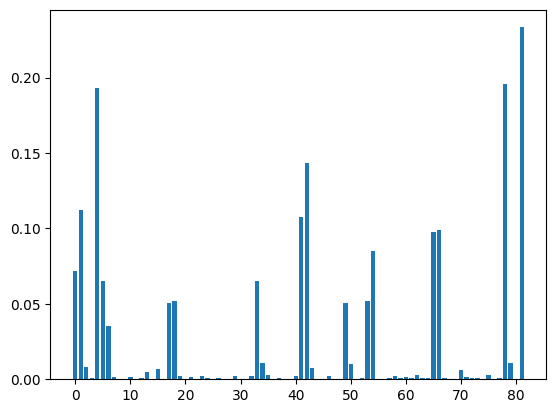

In [23]:
print(data_dict['neural']['refract_viol'])

plt.bar(np.arange(data_dict['neural']['units']), data_dict['neural']['refract_viol'])

In [7]:
brain_regions = {'ANT': 0, 'PoS': 1, 'CA1': 2, 'mPFC': 3}

units = data_dict['neural']['units']

neuron_groups = data_dict['neural']['neuron_groups']
        
neuron_regions = np.empty(units)
for key in neuron_groups.keys():
    neuron_regions[neuron_groups[key]] = brain_regions[key]

In [8]:
data_dict['covariates']['invalid_behaviour']

{'HD': [{'index': 0, 'length': 1792},
  {'index': 780032, 'length': 5632},
  {'index': 835329, 'length': 5632},
  {'index': 1201920, 'length': 9217},
  {'index': 1447681, 'length': 14847},
  {'index': 1483520, 'length': 10241},
  {'index': 1585921, 'length': 15871},
  {'index': 1602305, 'length': 15871},
  {'index': 1625856, 'length': 5121},
  {'index': 1987840, 'length': 15873},
  {'index': 2127105, 'length': 16383},
  {'index': 2198272, 'length': 20480},
  {'index': 2235649, 'length': 25600},
  {'index': 2274561, 'length': 24064},
  {'index': 2315520, 'length': 21505},
  {'index': 2793729, 'length': 20992},
  {'index': 3657984, 'length': 2561},
  {'index': 4149505, 'length': 5631},
  {'index': 5873920, 'length': 4096},
  {'index': 21203713, 'length': 3072},
  {'index': 23900417, 'length': 2560},
  {'index': 24967424, 'length': 2561},
  {'index': 26272001, 'length': 5119},
  {'index': 32803585, 'length': 2559}],
 'XY': [{'index': 0, 'length': 1792}]}

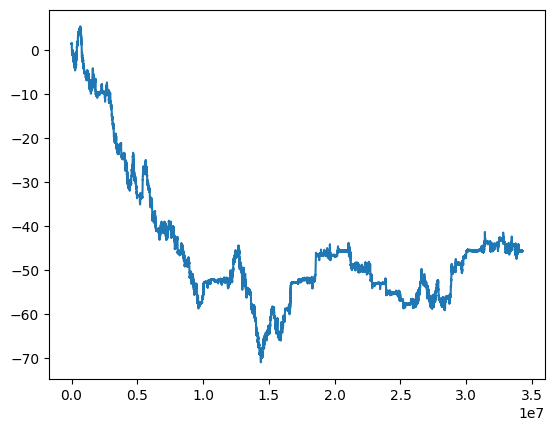

In [9]:
plt.plot(data_dict['covariates']['hd'][:])

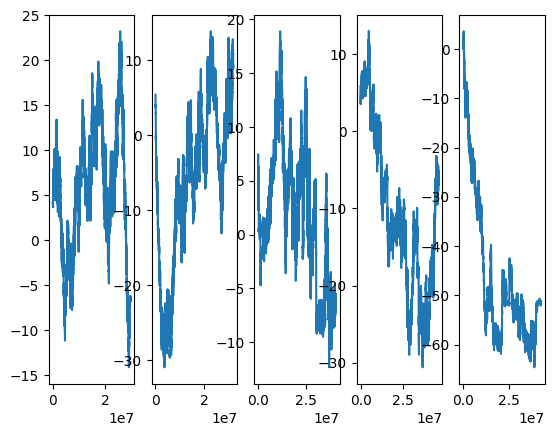

In [10]:
fig, ax = plt.subplots(1, 5)
for k in range(5):
    data_dict = pickle.load(open(datadir+'/th1_{}_{}_{}.p'.format(mouse_ids[k], session_ids[k], phase), 'rb'))
    ax[k].plot(data_dict['covariates']['hd'][:])

In [11]:
# resample to 1 ms
covariates = (
    data_dict['covariates']['x'], 
    data_dict['covariates']['y'], 
    np.unwrap(data_dict['covariates']['hd']), 
)
units = data_dict['neural']['units']

bin_size = 20  # original data at 20k Hz
tbin, resamples, rc_t, (rx_t, ry_t, rhd_t,) = utils.neural.bin_data(
    bin_size, data_dict['sample_bin'], data_dict['neural']['spike_time_inds'], data_dict['use_sample_num'], 
    covariates, average_behav=True)

rhd_t = rhd_t % (2*np.pi)
print('time bin: ', tbin, ' units: ', units)



inval_behav = data_dict['covariates']['invalid_behaviour']
print('invalid time intervals: ', inval_behav)

if inval_behav['XY'][0]['index'] == 0:  # remove invalid region at start
    start_ind = int(np.ceil(inval_behav['XY'][0]['length'] / bin_size))
    resamples -= start_ind
    rc_t = rc_t[:, start_ind:]
    rx_t = rx_t[start_ind:]
    ry_t = ry_t[start_ind:]
    rhd_t = rhd_t[start_ind:]

time bin:  0.001  units:  41
invalid time intervals:  {'HD': [{'index': 0, 'length': 1280}, {'index': 30908161, 'length': 23551}, {'index': 35290368, 'length': 20480}], 'XY': [{'index': 0, 'length': 1280}]}


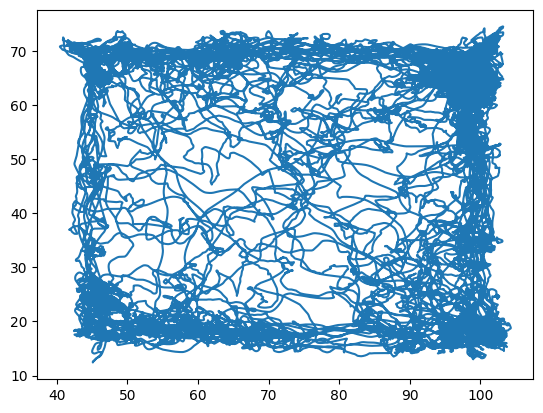

In [8]:
plt.plot(rx_t, ry_t)

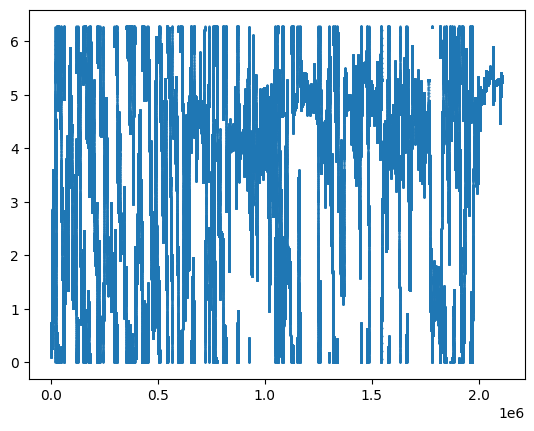

In [9]:
plt.scatter(np.arange(resamples), rhd_t[:] % (2*np.pi), s=1, marker='.')

In [10]:
# remove invalid data
inval_behav = data_dict['covariates']['invalid_behaviour']
print('invalid time intervals: ', inval_behav)
if len(inval_behav['HD']) > 0:  # assume XY invalids is subset
    if inval_behav['HD'][-1]['index'] + inval_behav['HD'][-1]['length'] == resamples:  # remove invalid region at start
        end_cut = int(np.ceil(inval_behav['HD'][-1]['length'] / bin_size))
        resamples -= end_cut
        rc_t = rc_t[:, :-end_cut]
        rx_t = rx_t[:-end_cut]
        ry_t = ry_t[:-end_cut]
        rhd_t = rhd_t[:-end_cut]

    if inval_behav['HD'][0]['index'] == 0:  # remove invalid region at start
        start_ind = int(np.ceil(inval_behav['HD'][0]['length'] / bin_size))
        resamples -= start_ind
        rc_t = rc_t[:, start_ind:]
        rx_t = rx_t[start_ind:]
        ry_t = ry_t[start_ind:]
        rhd_t = rhd_t[start_ind:]
        
r_t_spike = []
for u in range(units):
    r_t_spike.append(utils.neural.binned_to_indices(rc_t[u]))

# binning of covariates and analysis
bins_hd = 60
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)
hd_rate, hd_prob = utils.neural.IPP_model(tbin, 0.0, (rhd_t,), (bin_hd,), r_t_spike, divide=True)
hd_MI = utils.neural.spike_var_MI(hd_rate, hd_prob)
filter_win = 41
centre_win = filter_win//2
sigma = 6
sfilter = np.exp(-0.5*(np.arange(filter_win)-centre_win)**2/sigma**2)
sfilter = sfilter / sfilter.sum()
sm_tun = utils.neural.smooth_hist(hd_rate, sfilter, ['periodic'], dev='cpu')
coherence, sparsity = utils.neural.geometric_tuning(hd_rate, sm_tun, hd_prob)


invalid time intervals:  {'HD': [{'index': 0, 'length': 1280}, {'index': 30908161, 'length': 23551}, {'index': 35290368, 'length': 20480}], 'XY': [{'index': 0, 'length': 1280}]}


Mutual information $$I(x;\text{spike}) = \int p(x) \, \lambda(x) \, \log{\frac{\lambda(x)}{\langle \lambda \rangle}} \, \mathrm{d}x,$$


Local variation measure
            $$LV = 3 \langle \left( \frac{\Delta_{k-1} - \Delta_{k}}{\Delta_{k-1} + \Delta_{k}} \right)^2 \rangle$$


In [11]:
# select cells based on criterion
criterion = {'refractory': 2.0, 'spatial_info': 0.5, 'sparsity': 0.2}
hdc_unit = np.zeros(units).astype(bool)
for u in range(units):
    if ('spatial_info' in criterion and hd_MI[u] < criterion['spatial_info']) or \
       ('coherence' in criterion and coherence[u] < criterion['coherence']) or \
       ('refractory' in criterion and data_dict['neural']['refract_viol'][u] > criterion['refractory']) or \
       ('sparsity' in criterion and sparsity[u] < criterion['sparsity']):
        continue
    hdc_unit[u] = True


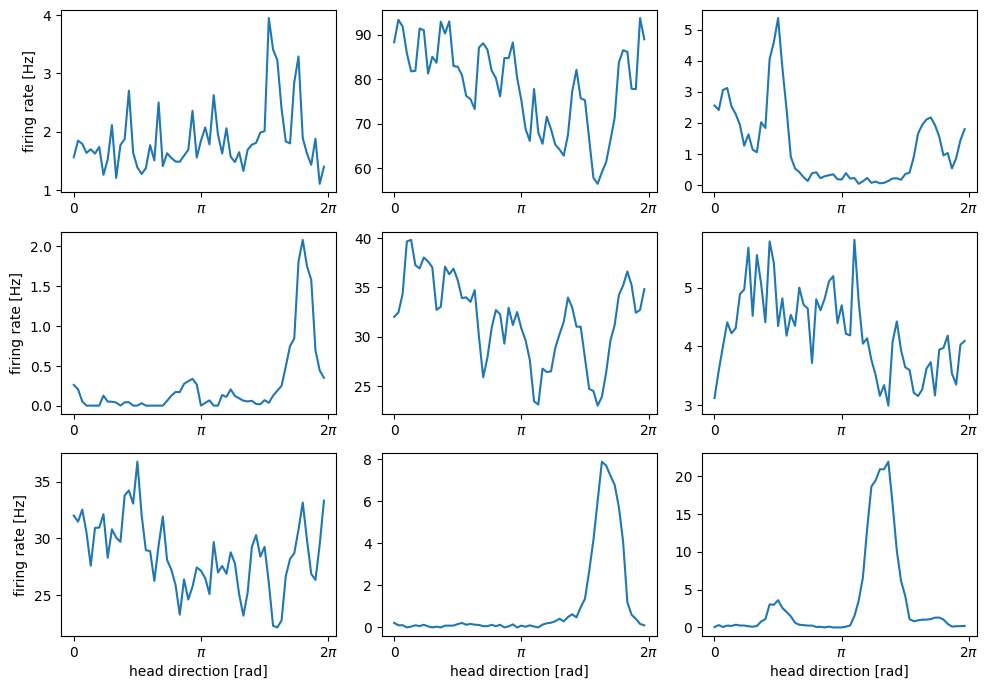

In [20]:
plt.figure(figsize=(10, 7))


for i in range(2,11):
    plt.subplot(3, 3, i-1)
    plt.plot(hd_rate[i])
    plt.xticks(ticks=(0, 30, 60), labels=('0', '$\pi$', '$2\pi$'))
    if i >= 8:
        plt.xlabel('head direction [rad]')
    if (i-2) % 3 == 0:
        plt.ylabel('firing rate [Hz]')

plt.tight_layout()
plt.show()

(60,)
(60,)
7323.396172507298


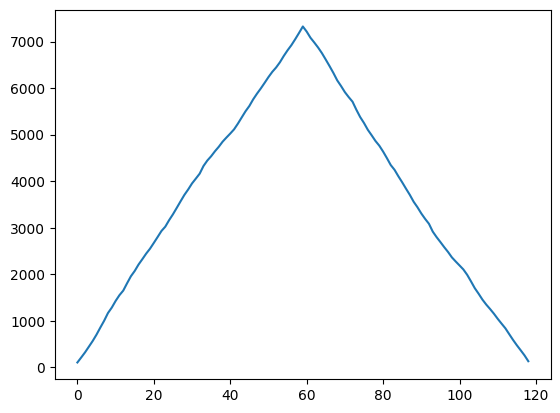

In [13]:
# compute cross correlations

# neurons to compare
ne1 = 7
ne2 = 8
print(hd_rate[ne1, :].shape)
print(hd_rate[ne2, :].shape)

correlations = np.correlate(hd_rate[ne1, :], hd_rate[ne2, :], mode='full')

fig, ax = plt.subplots()
ax.plot(correlations)
print(np.max(correlations))

In [14]:
np.array(unit_used)

NameError: name 'unit_used' is not defined

In [ ]:
# Mouse12 has ANT-CA1
edge = np.where(np.array(unit_used) > max(neuron_groups['ANT']))[0]
print(edge)
unit_used[20]

In [ ]:
# Mouse28 have PoS-ANT
print(np.where(np.array(unit_used) > max(neuron_groups['PoS']))[0])
print(np.where(np.array(unit_used) > max(neuron_groups['ANT']))[0])
edge = np.array([15])
print(unit_used[15])

In [ ]:
data_dict['covariates'].keys()

In [ ]:
left_x = rx_t.min()
right_x = rx_t.max()
bottom_y = ry_t.min()
top_y = ry_t.max()

arena = np.array([left_x, right_x, bottom_y, top_y])

spktrain = rc_t[unit_used]

import os

if not os.path.exists('../checkpoint'):
    os.makedirs('../checkpoint')

np.savez_compressed('../checkpoint/{}_{}'.format(session_id, phase), spktrain=spktrain, 
                    arena=arena, x_t=rx_t, y_t=ry_t, hd_t=rhd_t, region_edge=edge) # edge is the start of new brain region

In [ ]:
# Mouse12
left_over = np.delete(np.arange(units), unit_used)
print(np.where(left_over > max(neuron_groups['ANT'])))
print(np.where(left_over > max(neuron_groups['mPFC'])))

edge = np.array([34, 57])

In [ ]:
# Mouse28
left_over = np.delete(np.arange(units), unit_used)
print(np.where(left_over > max(neuron_groups['PoS']))[0])

edge = np.array([38])

In [ ]:
# leftover units
# Mouse28 have PoS-ANT
# Mouse12 has ANT-CA1

spktrain = rc_t[left_over]
np.savez_compressed('../checkpoint/{}_{}_leftover'.format(session_id, phase), spktrain=spktrain, 
                    x_t=rx_t, y_t=ry_t, hd_t=rhd_t, region_edge=edge)

In [ ]:
u = 66#left_over[8] # 8, 
plt.plot(hd_rate[u])

In [ ]:
spktrain = rc_t[left_over]

In [89]:
spktrain.shape

(49, 2286282)